# TP : Analyse de sentiments dans les critiques de films

## Objectifs

1. Représenter des données textuelles de manière simple.
2. Utiliser un modèle d'apprentissage statistique basique pour une tâche d'analyse de sentiments.
3. Tenter d'améliorer ces représentations avec des outils venus du traitement automatique du langage
5. Comparer les résultats avec une méthode coûteuse état-de-l'art: *fine-tuner* un modèle *Bert*.

## Dépendances nécessaires

Pour les objectifs 2. et 3., on aura besoin des packages suivants:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Les deux sont disponibles avec Anaconda: https://anaconda.org/anaconda/nltk et https://anaconda.org/anaconda/scikit-learn

Pour l'objectif 4., il faudra installer le package ```transformers```: https://huggingface.co/transformers/index.html

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import gdown

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 71.1 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
     |████████████████████████████████| 6.6 MB 55.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
gdown.download("http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", output="aclImdb_v1.tar.gz", quiet=False)
!tar xzf /content/aclImdb_v1.tar.gz

Downloading...
From: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
To: /content/aclImdb_v1.tar.gz
100%|██████████| 84.1M/84.1M [00:02<00:00, 34.9MB/s]


## Charger les données

On récupère les données textuelles dans la variable *train_texts*;

On récupère les labels dans la variable $train_labels$: $0$ indique que la critique correspondante est négative tandis que $1$ qu'elle est positive.

In [4]:
from glob import glob
# We get the files from the path: ./data/imdb1/neg for negative reviews, and ./data/imdb1/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))

"""
test_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'test', 'neg', '*.txt')))
test_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'test', 'pos', '*.txt')))
"""

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

"""
test_texts_neg = [open(f, encoding="utf8").read() for f in test_filenames_neg]
test_texts_pos = [open(f, encoding="utf8").read() for f in test_filenames_pos]
test_texts = test_texts_neg + test_texts_pos
"""

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=np.int)
train_labels[:len(train_texts_neg)] = 0.

"""
test_labels = np.ones(len(test_texts), dtype=np.int)
test_labels[:len(test_texts_neg)] = 0.
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


'\ntest_labels = np.ones(len(test_texts), dtype=np.int)\ntest_labels[:len(test_texts_neg)] = 0.\n'

Exemple de document: 

In [5]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**Dans tout ce TP, l'impact de vos choix sur les résultats dépendra grandement de la quantité de données utilisée:**
essayez de faire varier le paramètre ```k``` dans l'encart suivant !

In [6]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 2
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Nombre de documents:', len(train_texts_reduced))

Nombre de documents: 12500


On peut utiliser une fonction utilitaire de sklearn, ```train_test_split```, pour la séparation des données en ensembles d'entraînement et de validation:

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

## Représentation adaptée des documents

Notre modèle, comme la plupart des modèles appliqués aux données textuelles, utilise les comptes d'occurences de mots dans un document. Ainsi, une manière très pratique de représenter un document est d'utiliser un vecteur "Bag-of-Words" (BoW), contenant les comptes de chaque mot (indifférement de leur ordre d'apparition) dans le document. 

Si on considère l'ensemble de tous les mots apparaissant dans nos $T$ documents d'apprentissage, que l'on note $V$ (Vocabulaire), on peut créer **un index**, qui est une bijection associant à chaque mot $w$ un entier, qui sera sa position dans $V$. 

Ainsi, pour un document extrait d'un ensemble de documents contenant $|V|$ mots différents, une représentation BoW sera un vecteur de taille $|V|$, dont la valeur à l'indice d'un mot $w$ sera son nombre d'occurences dans le document. 

On peut utiliser la classe **CountVectorizer** de scikit-learn pour obtenir de telles représentations:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

Exemple d'utilisation:

In [10]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())
Bow.toarray()

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

Attention: vérifiez la mémoire que les représentations vont occuper (étant donné la façon dont elles sont construites). Quel argument de ```CountVectorizer``` permet d'éviter le problème ? 

Pour gérer le problème de mémoire il est nécéssaire de diminuer la taille du vocabulaire.

Pour ce faire 2 arguments peuvent être utilisés: 

- ``max_features`` qui garde ajoute dans le vocabulaire les **N** mots les plus fréquents. 

- ``min_df`` qui ignore les mots dont la fréquence de document est strictement inférieure au seuil donné. 


Pour gérer le problème de mémoire, j'ai décidé d'utiliser le paramètre ``max_features`` que j'ai fixé à 10 000. Cela signifie que les 10 000 premiers mots pour lesquels la fréquence d'apparition est la plus élevée sont sélectionnés  

In [11]:
# Create and fit the vectorizer to the training data
vectorizer_train_splt = CountVectorizer(max_features=10000)
bow_train_splt = vectorizer_train_splt.fit_transform(train_texts_splt)
train_splt_features_names = vectorizer_train_splt.get_feature_names()

print("\n\nTrain reduced features names")
print(train_splt_features_names)

print("\n\nVocabulary")
print(vectorizer_train_splt.vocabulary_)

bow_train_splt = bow_train_splt.toarray()
print("\n\nBoW train dimension")
print(bow_train_splt)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)




Train reduced features names
['00', '000', '01', '10', '100', '1000', '11', '12', '13', '13th', '14', '15', '150', '16', '17', '18', '18th', '19', '1920s', '1930', '1930s', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1940s', '1941', '1942', '1943', '1944', '1945', '1946', '1948', '1949', '1950', '1950s', '1951', '1953', '1955', '1957', '1959', '1960', '1960s', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1970s', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1980s', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1990s', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19th', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '20s', '20th', '21', '21st', '22', '23', '24', '25', '250', '26', '27', '28', '2nd', '30', '300', '3000', '30s', '33', '35', '3d', '3rd', '40', '40s', '45', '4th', '50

In [12]:
# Look at the shape of the obtained array
print("Shape of bow_train_reduced_vectors")
print(bow_train_splt.shape)

Shape of bow_train_reduced_vectors
(10000, 10000)


In [13]:
# Transform the validation data
vectorizer_val_splt = CountVectorizer(max_features=10000)
bow_val_splt = vectorizer_val_splt.fit_transform(val_texts)
val_splt_features_names = vectorizer_val_splt.get_feature_names()

print("\n\nTrain reduced features names")
print(val_splt_features_names)

print("\n\nVocabulary")
print(vectorizer_val_splt.vocabulary_)

bow_val_splt = bow_val_splt.toarray()
print("\n\nBow train reduced vectors")
print(bow_val_splt)

print("\n\nBoW validation shape")
print(bow_val_splt.shape)



Train reduced features names
['00', '000', '01', '10', '100', '101', '11', '11th', '12', '13', '13th', '14', '15', '16', '17', '17th', '18', '1890', '1894', '19', '1912', '1915', '1917', '1920', '1920s', '1922', '1928', '1929', '1930', '1930s', '1933', '1934', '1935', '1936', '1939', '1940', '1940s', '1942', '1943', '1944', '1945', '1946', '1948', '1949', '1950', '1950s', '1951', '1952', '1953', '1954', '1955', '1956', '1958', '1959', '1960', '1960s', '1961', '1962', '1965', '1966', '1967', '1968', '1969', '1970', '1970s', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1980s', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1990s', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19th', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '20s', '20th', '21', '21st', '22', '23', '24', '25', '27', '28', '2d', '2nd', '30', '300', '3000', '30s', '31', '345', 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


On va utiliser le ```MultinomialNB``` de scikit-learn, une implémentation du modèle Bayésien naïf. Ici, l'hypothèse naïve est que les différentes variables (mots) d'une critique sont indépendantes entre elles.

In [14]:
from sklearn.naive_bayes import MultinomialNB

In [15]:
# Create the model, train it and do the prediction 

# Build the model 
clf_multi_NB = MultinomialNB()
clf_multi_NB.fit(bow_train_splt, train_labels_splt)

predictions = clf_multi_NB.predict(bow_val_splt)

print("Predictions")
predictions



Predictions


array([1, 1, 1, ..., 1, 1, 1])

In [16]:
import pandas as pd
pd.DataFrame(predictions).value_counts()

1    2443
0      57
dtype: int64

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

---- Classification report ----
              precision    recall  f1-score   support

     positif       0.39      0.02      0.03      1267
     negatif       0.49      0.97      0.65      1233

    accuracy                           0.49      2500
   macro avg       0.44      0.49      0.34      2500
weighted avg       0.44      0.49      0.34      2500



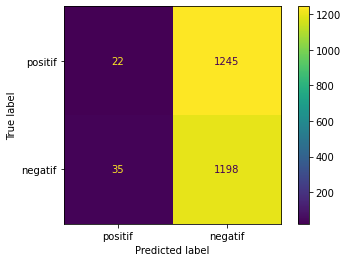

In [18]:
# Show the results in a readable format
print("---- Classification report ----")

report_classification = classification_report(val_labels, predictions, target_names=["positif", "negatif"], output_dict=True)

print(classification_report(val_labels, predictions, target_names=["positif", "negatif"]))

cm = confusion_matrix(val_labels, predictions)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=["positif", "negatif"])

cm_disp.plot()
plt.show()

On peut jeter un oeil aux *features* construites par le ```vectorizer```. Comment pourrait-on les améliorer ? 

In [ ]:
print(vectorizer.get_feature_names()[:100])

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Améliorer les représentations BoW

Les arguments du ```vectorizer``` vont nous permettre d'agir facilement sur la façon dont les données sont représentées. On peut donc chercher à améliorer nos représentations *Bag-of-words*:

#### Ne pas prendre en compte les mots trop fréquents:

On peut utiliser l'option ```max_df=1.0``` pour modifier la quantité de mots pris en compte. 

#### Essayer différentes granularités:

Plutôt que de simplement compter les mots, on peut compter les séquences de mots - de taille limitée, bien sur. 
On appelle une séquence de $n$ mots un $n$-gram: essayons d'utiliser les 2 et 3-grams (bi- et trigrams).
On peut aussi tenter d'utiliser les séquences de caractères à la place de séquences de mots.

On s'intéressera aux options ```analyzer='word'``` et ```ngram_range=(1, 2)``` que l'on changera pour modifier la granularité. 

**Encore une fois: avoir recours à ces features aura probablement plus d'impact si la quantité de données d'entraînement à notre disposition est limitée !**

Pour accélérer les expériences, utilisez l'outil ```Pipeline``` de scikit-learn. 

In [19]:
from sklearn.pipeline import Pipeline

On fait varier les paramètres suivants :
- ``max_df`` = [0, 0.2, 0.5, 0.7, 0.9, 1]
- ``ngram_range`` = [(1,1), (1,2), (1,3),(2,2), (2,3), (3,3)]
- ``analyzer`` = ["word", "char", "char_wb"]

Le paramètre ``max_features`` reste fixé à **10 000**



0.2
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.5
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.7
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.9
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.2
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.5
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.7
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.9
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.2
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.5
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.7
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
0.9
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
Pipe with {analyzer=word, max_df=0.2, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.83      0.87      0.85      1250
     negatif       0.86      0.82      0.84      1250

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



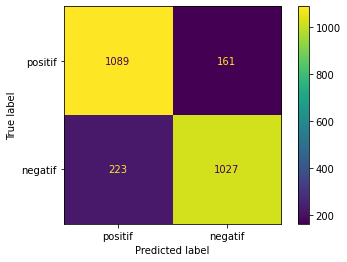



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.2, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.87      0.86      0.87      1250
     negatif       0.86      0.87      0.87      1250

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500



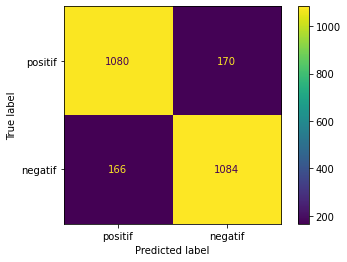



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.2, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.87      0.85      0.86      1250
     negatif       0.86      0.88      0.87      1250

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



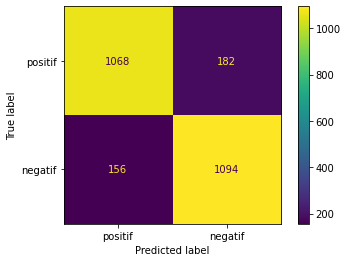



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.2, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.86      0.83      0.84      1250
     negatif       0.84      0.86      0.85      1250

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



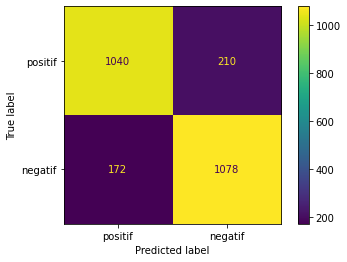



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.2, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.86      0.82      0.84      1250
     negatif       0.83      0.86      0.84      1250

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



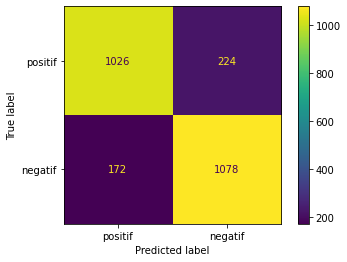



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.2, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.80      0.79      0.79      1250
     negatif       0.79      0.80      0.80      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



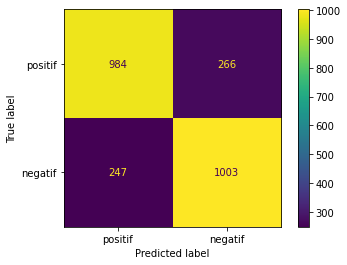



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.5, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.82      0.87      0.85      1250
     negatif       0.87      0.81      0.84      1250

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



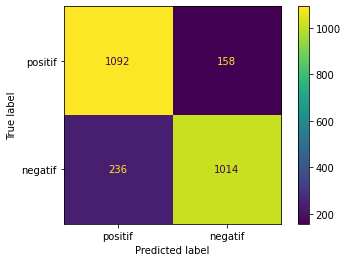



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.5, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.86      0.86      0.86      1250
     negatif       0.86      0.86      0.86      1250

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



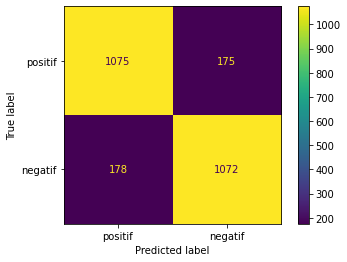



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.5, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.86      0.85      0.86      1250
     negatif       0.85      0.86      0.86      1250

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



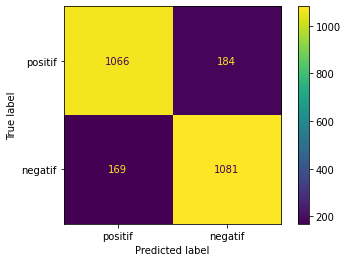



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.5, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.85      0.83      0.84      1250
     negatif       0.84      0.86      0.85      1250

    accuracy                           0.84      2500
   macro avg       0.85      0.84      0.84      2500
weighted avg       0.85      0.84      0.84      2500



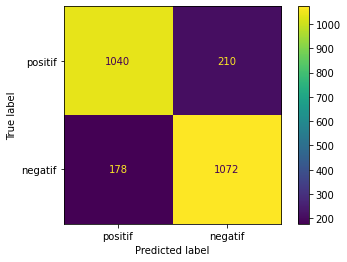



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.5, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.85      0.82      0.84      1250
     negatif       0.83      0.86      0.84      1250

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



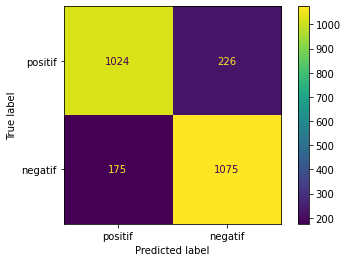



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.5, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.80      0.78      0.79      1250
     negatif       0.79      0.80      0.80      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



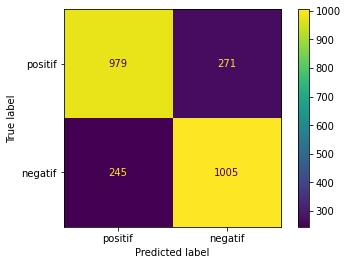



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.7, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.81      0.87      0.84      1250
     negatif       0.86      0.80      0.83      1250

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.83      2500
weighted avg       0.84      0.84      0.83      2500



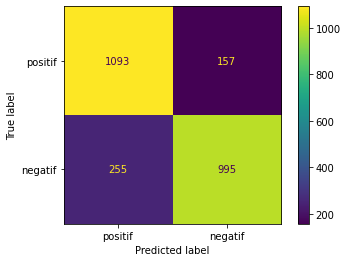



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.7, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.85      0.86      0.85      1250
     negatif       0.86      0.85      0.85      1250

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



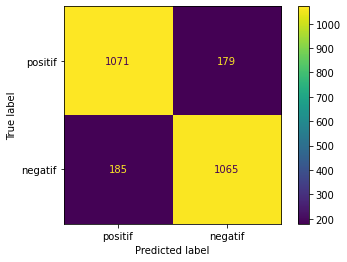



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.7, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.86      0.85      0.85      1250
     negatif       0.85      0.86      0.86      1250

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



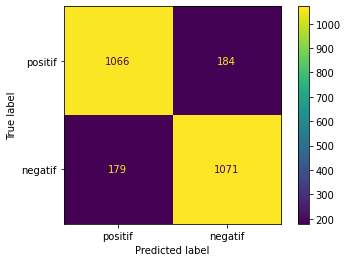



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.7, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.85      0.83      0.84      1250
     negatif       0.84      0.86      0.85      1250

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



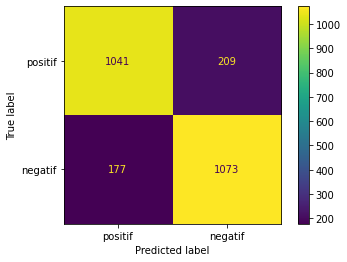



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.7, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.85      0.82      0.84      1250
     negatif       0.83      0.86      0.84      1250

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



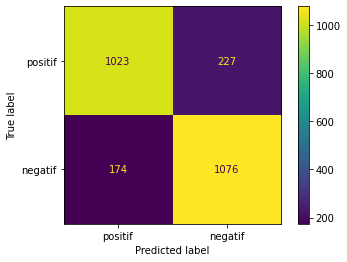



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.7, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.80      0.78      0.79      1250
     negatif       0.79      0.80      0.80      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



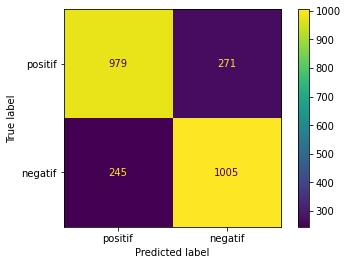



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.9, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.81      0.87      0.84      1250
     negatif       0.86      0.79      0.83      1250

    accuracy                           0.83      2500
   macro avg       0.83      0.83      0.83      2500
weighted avg       0.83      0.83      0.83      2500



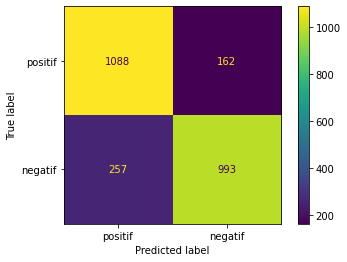



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.9, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.85      0.86      0.85      1250
     negatif       0.85      0.85      0.85      1250

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



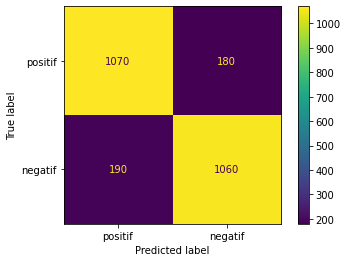



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.9, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.85      0.85      0.85      1250
     negatif       0.85      0.86      0.85      1250

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



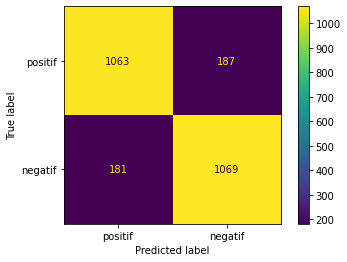



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.9, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.85      0.83      0.84      1250
     negatif       0.84      0.86      0.85      1250

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



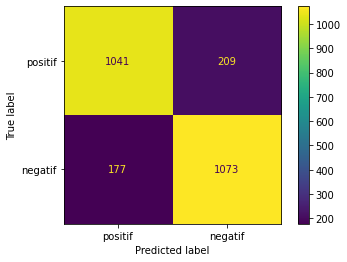



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.9, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.85      0.82      0.84      1250
     negatif       0.83      0.86      0.84      1250

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



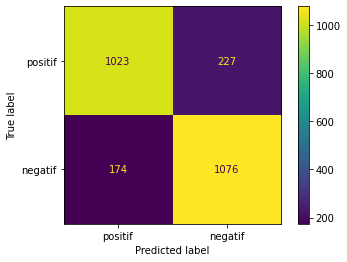



----------------------------------------------------


Pipe with {analyzer=word, max_df=0.9, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.80      0.78      0.79      1250
     negatif       0.79      0.80      0.80      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



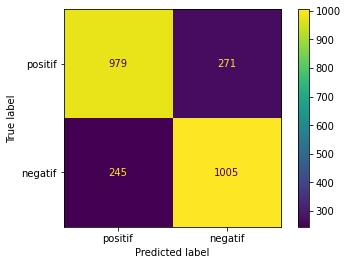



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.2, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.54      0.75      0.63      1250
     negatif       0.59      0.36      0.45      1250

    accuracy                           0.56      2500
   macro avg       0.57      0.56      0.54      2500
weighted avg       0.57      0.56      0.54      2500



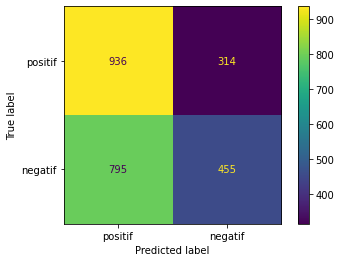



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.2, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.69      0.69      0.69      1250
     negatif       0.69      0.68      0.69      1250

    accuracy                           0.69      2500
   macro avg       0.69      0.69      0.69      2500
weighted avg       0.69      0.69      0.69      2500



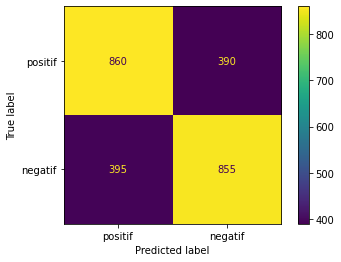



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.2, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.79      0.81      0.80      1250
     negatif       0.81      0.78      0.79      1250

    accuracy                           0.80      2500
   macro avg       0.80      0.80      0.80      2500
weighted avg       0.80      0.80      0.80      2500



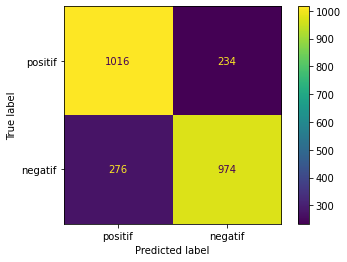



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.2, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.69      0.68      0.69      1250
     negatif       0.69      0.70      0.69      1250

    accuracy                           0.69      2500
   macro avg       0.69      0.69      0.69      2500
weighted avg       0.69      0.69      0.69      2500



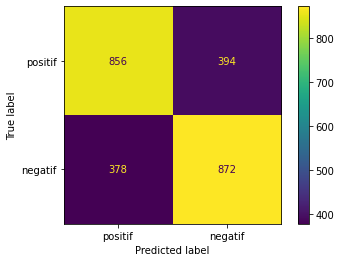



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.2, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.78      0.81      0.80      1250
     negatif       0.80      0.78      0.79      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



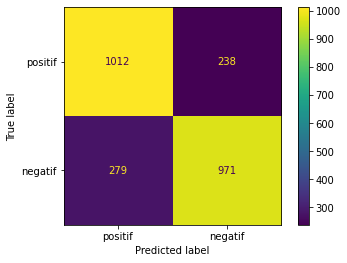



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.2, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.79      0.82      0.80      1250
     negatif       0.81      0.78      0.80      1250

    accuracy                           0.80      2500
   macro avg       0.80      0.80      0.80      2500
weighted avg       0.80      0.80      0.80      2500



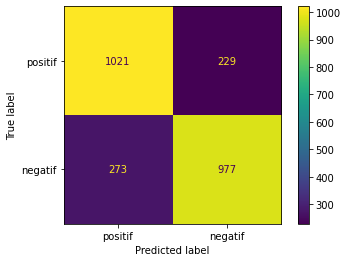



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.5, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.58      0.57      0.57      1250
     negatif       0.58      0.59      0.58      1250

    accuracy                           0.58      2500
   macro avg       0.58      0.58      0.58      2500
weighted avg       0.58      0.58      0.58      2500



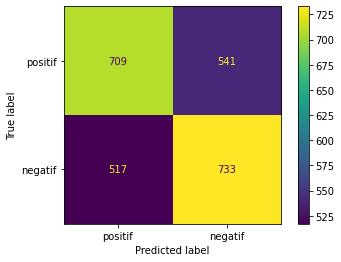



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.5, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.71      0.70      0.71      1250
     negatif       0.70      0.72      0.71      1250

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500



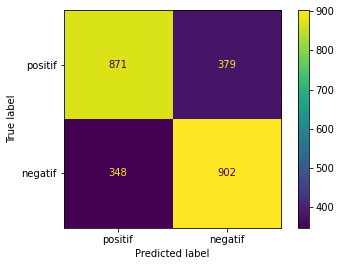



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.5, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.78      0.81      0.79      1250
     negatif       0.80      0.77      0.78      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



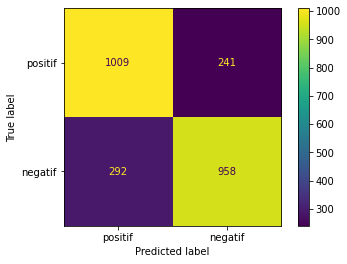



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.5, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.72      0.72      0.72      1250
     negatif       0.72      0.71      0.72      1250

    accuracy                           0.72      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.72      0.72      0.72      2500



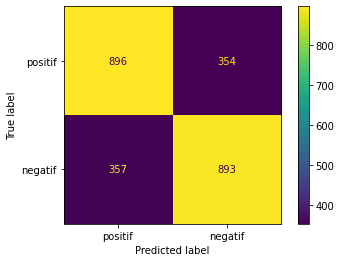



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.5, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.78      0.81      0.79      1250
     negatif       0.80      0.77      0.78      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



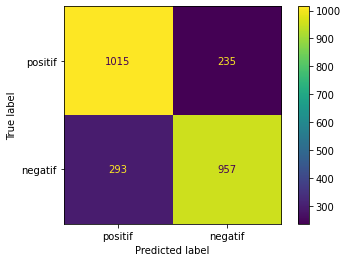



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.5, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.78      0.82      0.80      1250
     negatif       0.81      0.77      0.79      1250

    accuracy                           0.80      2500
   macro avg       0.80      0.80      0.80      2500
weighted avg       0.80      0.80      0.80      2500



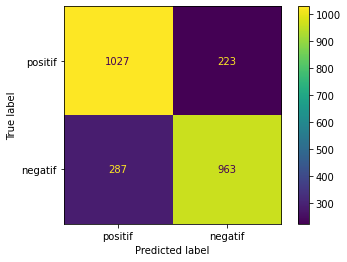



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.7, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.58      0.56      0.57      1250
     negatif       0.58      0.59      0.59      1250

    accuracy                           0.58      2500
   macro avg       0.58      0.58      0.58      2500
weighted avg       0.58      0.58      0.58      2500



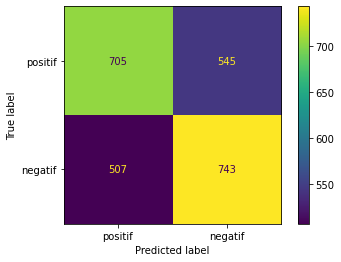



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.7, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.70      0.70      0.70      1250
     negatif       0.70      0.70      0.70      1250

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



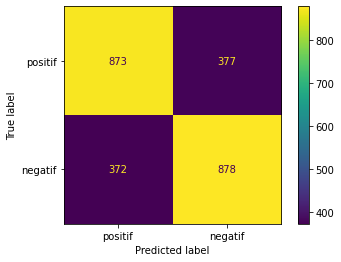



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.7, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.75      0.80      0.78      1250
     negatif       0.79      0.74      0.76      1250

    accuracy                           0.77      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.77      0.77      0.77      2500



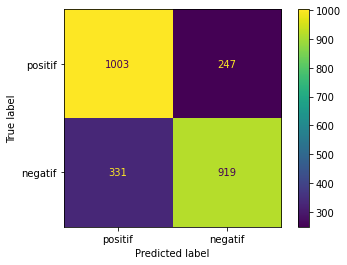



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.7, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.71      0.72      0.71      1250
     negatif       0.72      0.70      0.71      1250

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500



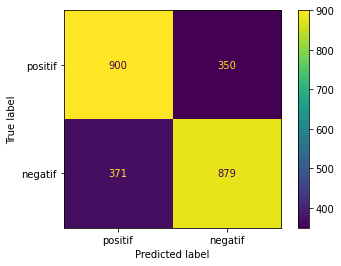



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.7, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.75      0.80      0.78      1250
     negatif       0.79      0.74      0.76      1250

    accuracy                           0.77      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.77      0.77      0.77      2500



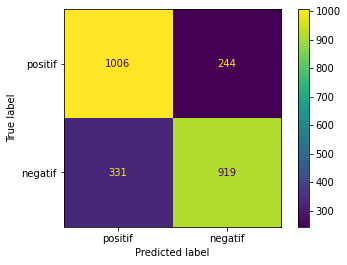



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.7, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.76      0.82      0.79      1250
     negatif       0.80      0.74      0.77      1250

    accuracy                           0.78      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.78      0.78      0.78      2500



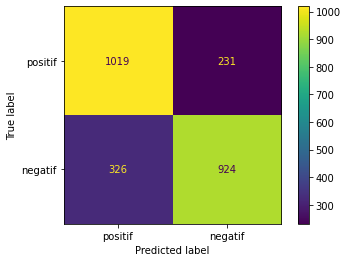



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.9, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.58      0.56      0.57      1250
     negatif       0.57      0.58      0.58      1250

    accuracy                           0.57      2500
   macro avg       0.57      0.57      0.57      2500
weighted avg       0.57      0.57      0.57      2500



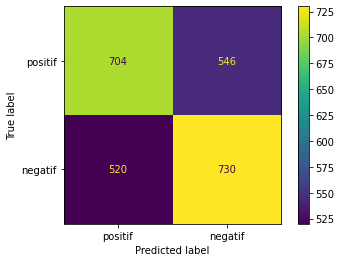



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.9, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.69      0.71      0.70      1250
     negatif       0.70      0.68      0.69      1250

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



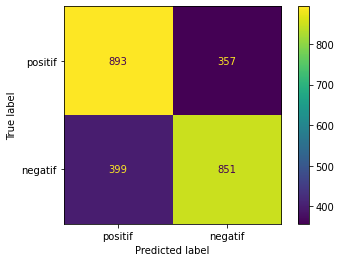



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.9, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.73      0.80      0.76      1250
     negatif       0.78      0.71      0.74      1250

    accuracy                           0.75      2500
   macro avg       0.76      0.75      0.75      2500
weighted avg       0.76      0.75      0.75      2500



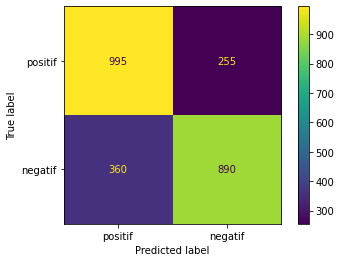



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.9, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.69      0.72      0.71      1250
     negatif       0.71      0.67      0.69      1250

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



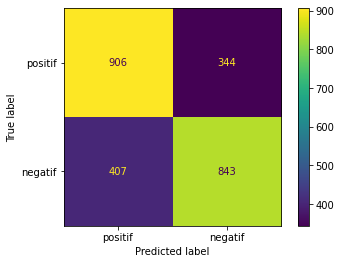



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.9, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.74      0.80      0.77      1250
     negatif       0.78      0.72      0.75      1250

    accuracy                           0.76      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.76      0.76      0.76      2500



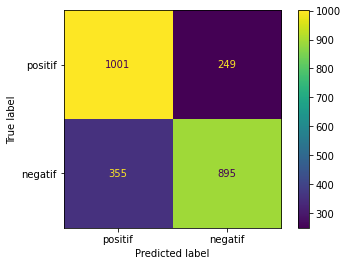



----------------------------------------------------


Pipe with {analyzer=char, max_df=0.9, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.74      0.81      0.77      1250
     negatif       0.79      0.72      0.75      1250

    accuracy                           0.76      2500
   macro avg       0.77      0.76      0.76      2500
weighted avg       0.77      0.76      0.76      2500



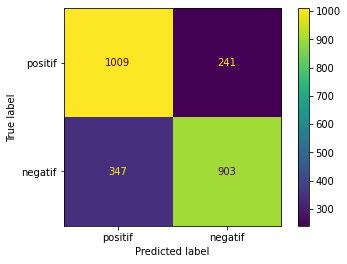



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.2, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.54      0.75      0.63      1250
     negatif       0.59      0.36      0.45      1250

    accuracy                           0.56      2500
   macro avg       0.57      0.56      0.54      2500
weighted avg       0.57      0.56      0.54      2500



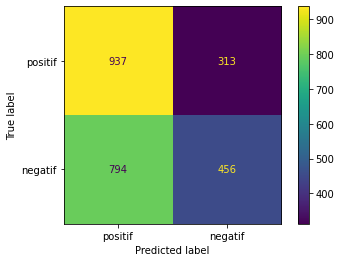



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.2, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.69      0.69      0.69      1250
     negatif       0.69      0.69      0.69      1250

    accuracy                           0.69      2500
   macro avg       0.69      0.69      0.69      2500
weighted avg       0.69      0.69      0.69      2500



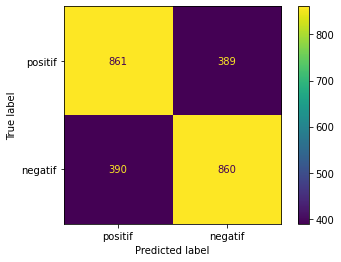



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.2, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.78      0.81      0.80      1250
     negatif       0.81      0.78      0.79      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



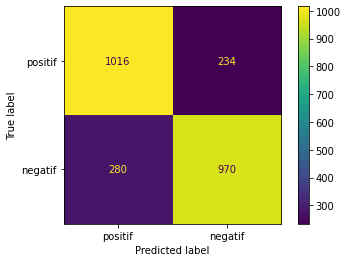



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.2, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.69      0.68      0.69      1250
     negatif       0.69      0.70      0.69      1250

    accuracy                           0.69      2500
   macro avg       0.69      0.69      0.69      2500
weighted avg       0.69      0.69      0.69      2500



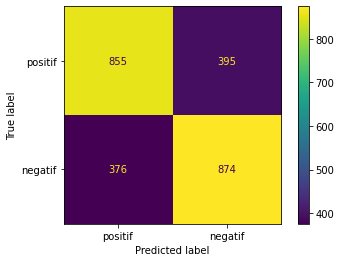



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.2, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.78      0.81      0.80      1250
     negatif       0.80      0.77      0.79      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



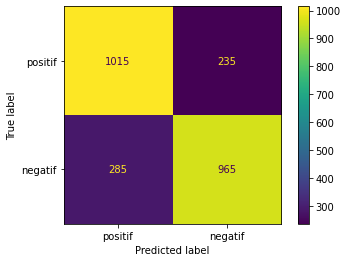



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.2, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.79      0.82      0.80      1250
     negatif       0.81      0.78      0.79      1250

    accuracy                           0.80      2500
   macro avg       0.80      0.80      0.80      2500
weighted avg       0.80      0.80      0.80      2500



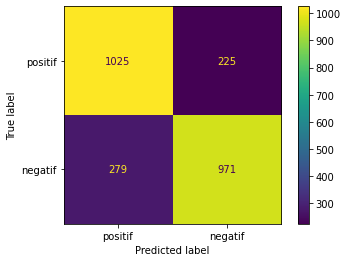



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.5, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.58      0.57      0.57      1250
     negatif       0.58      0.59      0.58      1250

    accuracy                           0.58      2500
   macro avg       0.58      0.58      0.58      2500
weighted avg       0.58      0.58      0.58      2500



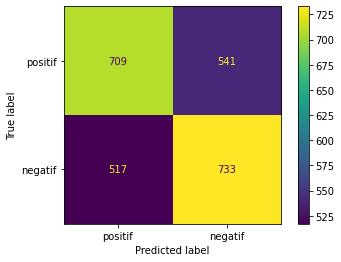



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.5, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.71      0.70      0.71      1250
     negatif       0.70      0.72      0.71      1250

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500



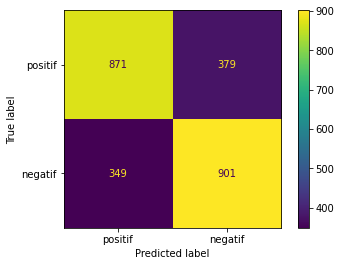



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.5, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.77      0.81      0.79      1250
     negatif       0.80      0.76      0.78      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



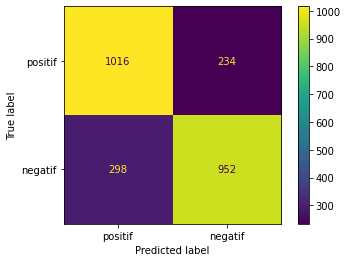



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.5, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.71      0.72      0.72      1250
     negatif       0.72      0.71      0.71      1250

    accuracy                           0.72      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.72      0.72      0.72      2500



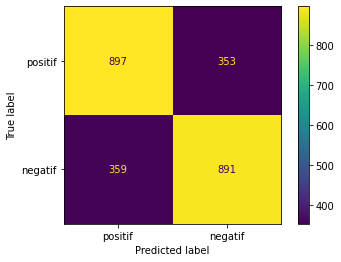



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.5, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.77      0.82      0.79      1250
     negatif       0.80      0.76      0.78      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



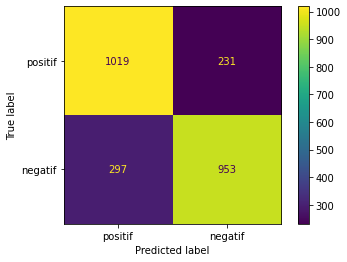



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.5, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.78      0.82      0.80      1250
     negatif       0.81      0.77      0.79      1250

    accuracy                           0.80      2500
   macro avg       0.80      0.80      0.80      2500
weighted avg       0.80      0.80      0.80      2500



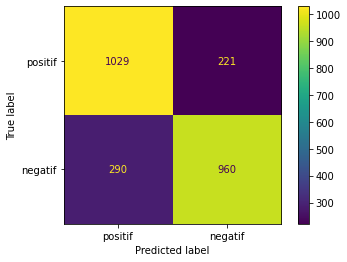



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.7, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.58      0.56      0.57      1250
     negatif       0.58      0.59      0.59      1250

    accuracy                           0.58      2500
   macro avg       0.58      0.58      0.58      2500
weighted avg       0.58      0.58      0.58      2500



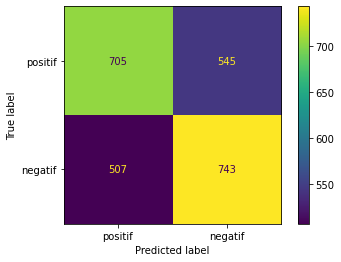



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.7, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.70      0.70      0.70      1250
     negatif       0.70      0.70      0.70      1250

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



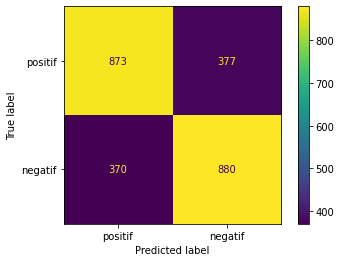



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.7, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.76      0.80      0.78      1250
     negatif       0.79      0.74      0.76      1250

    accuracy                           0.77      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.77      0.77      0.77      2500



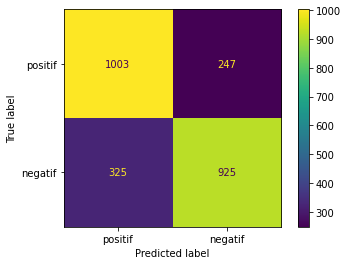



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.7, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.71      0.72      0.71      1250
     negatif       0.72      0.70      0.71      1250

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500



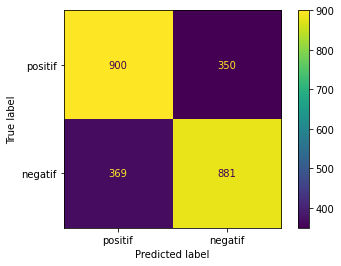



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.7, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.75      0.80      0.78      1250
     negatif       0.79      0.74      0.76      1250

    accuracy                           0.77      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.77      0.77      0.77      2500



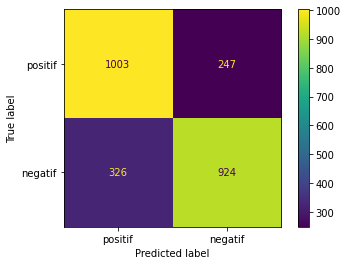



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.7, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.76      0.82      0.79      1250
     negatif       0.81      0.75      0.77      1250

    accuracy                           0.78      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.78      0.78      0.78      2500



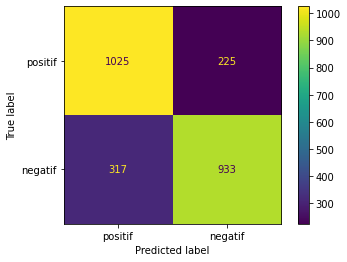



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.9, ngram_range=(1, 1)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.58      0.56      0.57      1250
     negatif       0.57      0.58      0.58      1250

    accuracy                           0.57      2500
   macro avg       0.57      0.57      0.57      2500
weighted avg       0.57      0.57      0.57      2500



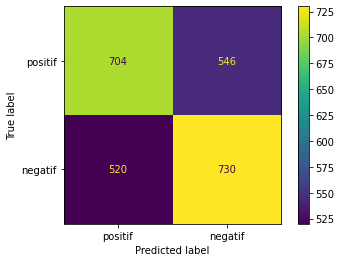



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.9, ngram_range=(1, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.69      0.71      0.70      1250
     negatif       0.70      0.68      0.69      1250

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



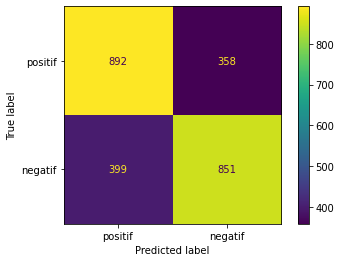



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.9, ngram_range=(1, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.74      0.80      0.77      1250
     negatif       0.78      0.72      0.75      1250

    accuracy                           0.76      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.76      0.76      0.76      2500



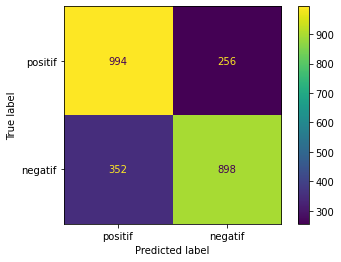



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.9, ngram_range=(2, 2)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.69      0.72      0.71      1250
     negatif       0.71      0.68      0.69      1250

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



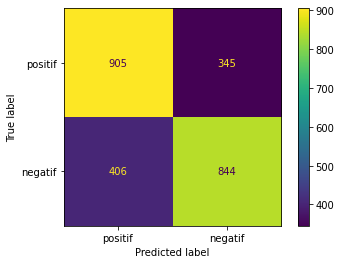



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.9, ngram_range=(2, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.74      0.80      0.77      1250
     negatif       0.78      0.72      0.75      1250

    accuracy                           0.76      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.76      0.76      0.76      2500



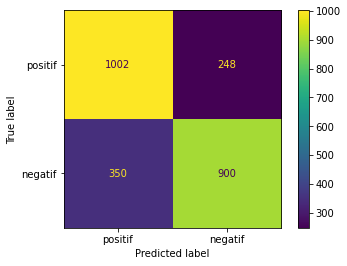



----------------------------------------------------


Pipe with {analyzer=char_wb, max_df=0.9, ngram_range=(3, 3)}
---- Classification report ----
              precision    recall  f1-score   support

     positif       0.75      0.81      0.78      1250
     negatif       0.80      0.73      0.76      1250

    accuracy                           0.77      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.77      0.77      0.77      2500



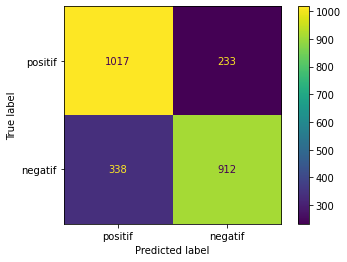



----------------------------------------------------


F1-Score
[0.8463054717173251, 0.8655996559351191, 0.8647853751861803, 0.8471646889297303, 0.8415314401622719, 0.7947881469633686, 0.8422464363710209, 0.8587997966717072, 0.8587949166169981, 0.844774567865199, 0.8395332201448955, 0.7935776733611507, 0.8349463719930594, 0.8543991613391694, 0.8547994191976769, 0.8455746989586774, 0.8395278774092227, 0.7935776733611507, 0.8321576356258438, 0.8519976319621114, 0.8527991521231162, 0.8455746989586774, 0.8395278774092227, 0.7935776733611507, 0.5393476830891503, 0.685998743994976, 0.7959424067848909, 0.6911873510338983, 0.7931443641081706, 0.7991377809190174, 0.5767609942932341, 0.7091552797158092, 0.7867112377487016, 0.7155995904634104, 0.7886862624939247, 0.7958662188852086, 0.5791027559007232, 0.7003988015952065, 0.7685386894388289, 0.7115796490600377, 0.7697211230688813, 0.7768778115598924, 0.5735538755871835, 0.6975146265281913, 0.7535652891700961, 0.6994091127629689, 0.7579648789407

In [ ]:
# Create a pipeline for each configuration
models = []

max_df = [0.2, 0.5, 0.7, 0.9]
ngram_range = [(1,1), (1,2), (1,3),(2,2), (2,3), (3,3)]
analyzer = ["word", "char", "char_wb"]

f1_score_list = list()

for i in analyzer:
  models_max_df = []
  for j in max_df:
    print(j)
    models_ngram = []
    for k in ngram_range:
      print(k)
      pipe = Pipeline([
                    ('vec', CountVectorizer(max_features=10000, analyzer=i, max_df=j, ngram_range=k)),
                    ('clf', MultinomialNB())
                    ])
      pipe.fit(train_texts_splt, train_labels_splt)
      models_ngram.append(pipe)

    models_max_df.append(models_ngram)
  models.append(models_max_df)

for n, i in enumerate(analyzer):
  for m, j in enumerate(max_df):
    for o, k in enumerate(ngram_range):
      print('Pipe with {analyzer=' + i + ", max_df=" + str(j) + ", ngram_range=" + str(k) + "}")
      preds = models[n][m][o].predict(val_texts)

      print("---- Classification report ----")
      report_classification = classification_report(val_labels, preds, target_names=["positif", "negatif"], output_dict=True)
      print(classification_report(val_labels, preds, target_names=["positif", "negatif"]))

      f1_score = report_classification['macro avg']['f1-score']
      f1_score_list.append(f1_score)

      cm = confusion_matrix(val_labels, preds)
      cm_disp = ConfusionMatrixDisplay(cm, display_labels=["positif", "negatif"])

      cm_disp.plot()
      plt.show() 
      print("\n\n----------------------------------------------------\n\n")

print("F1-Score")
print(f1_score_list)

In [ ]:
import pandas as pd
max_df = [0.2, 0.5, 0.7, 0.9]
ngram_range = [(1,1), (1,2), (1,3),(2,2), (2,3), (3,3)]
analyzer = ["word", "char", "char_wb"]

result_df = pd.DataFrame(columns=['analyzer', 'max_df','ngram_range'])

for i in analyzer:
  for j in max_df:
    for k in ngram_range:
      new_row = {'analyzer':i, 'max_df':j, 'ngram_range':str(k)}
      result_df = result_df.append(new_row, ignore_index=True)

result_df.insert (0, "f1-score", f1_score_list)

In [ ]:
result_df

f1-score analyzer  max_df ngram_range
0   0.846305     word     0.2      (1, 1)
1   0.865600     word     0.2      (1, 2)
2   0.864785     word     0.2      (1, 3)
3   0.847165     word     0.2      (2, 2)
4   0.841531     word     0.2      (2, 3)
..       ...      ...     ...         ...
67  0.697119  char_wb     0.9      (1, 2)
68  0.756441  char_wb     0.9      (1, 3)
69  0.699421  char_wb     0.9      (2, 2)
70  0.760401  char_wb     0.9      (2, 3)
71  0.771196  char_wb     0.9      (3, 3)

[72 rows x 4 columns]

In [ ]:
#!pip install -U hiplot

In [ ]:
import hiplot as hip
result_hiplot = hip.Experiment.from_dataframe(result_df)
result_hiplot.display()

<IPython.core.display.Javascript object>

### Output ``HiPlot``

Pour éviter d'avoir installer ``HiPlot`` j'ai intégrer des captures d'écran du graphe généré par ``HiPlot``

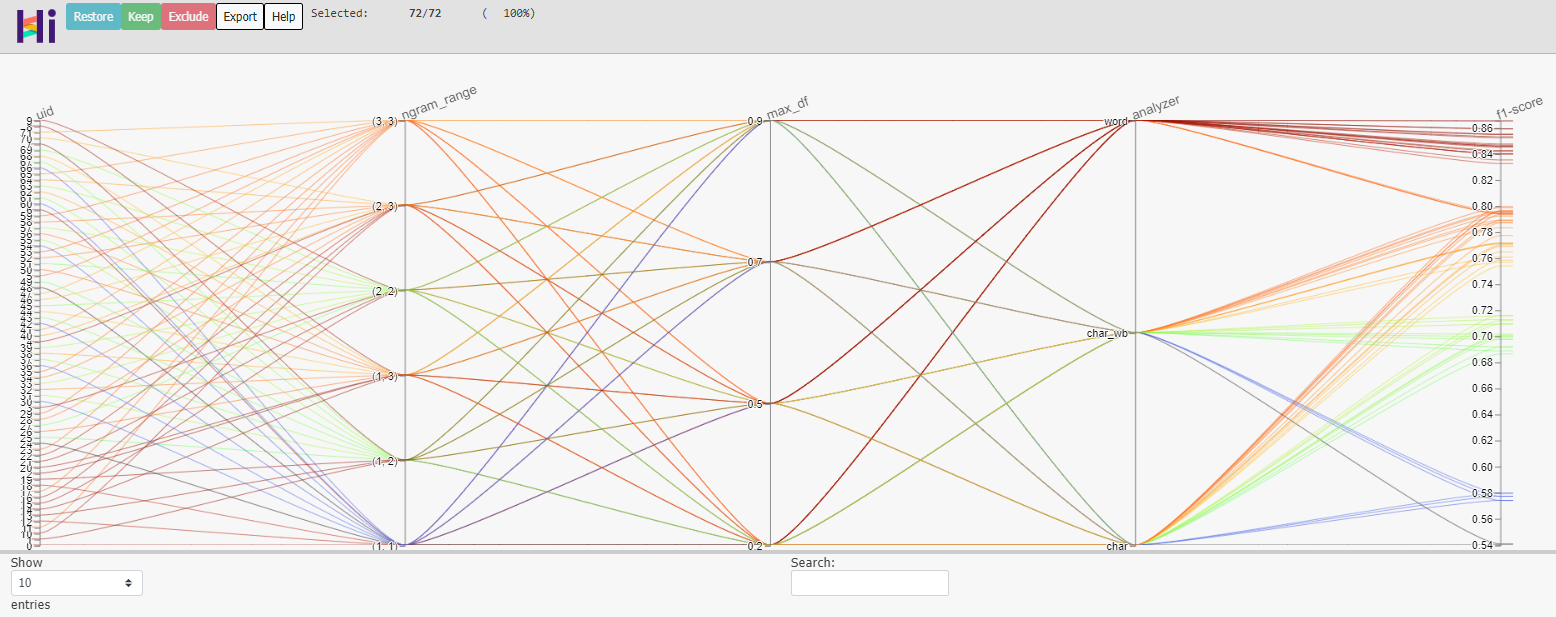

### Output ``HiPlot``

#### La combinaison des meilleures hyperparamètres

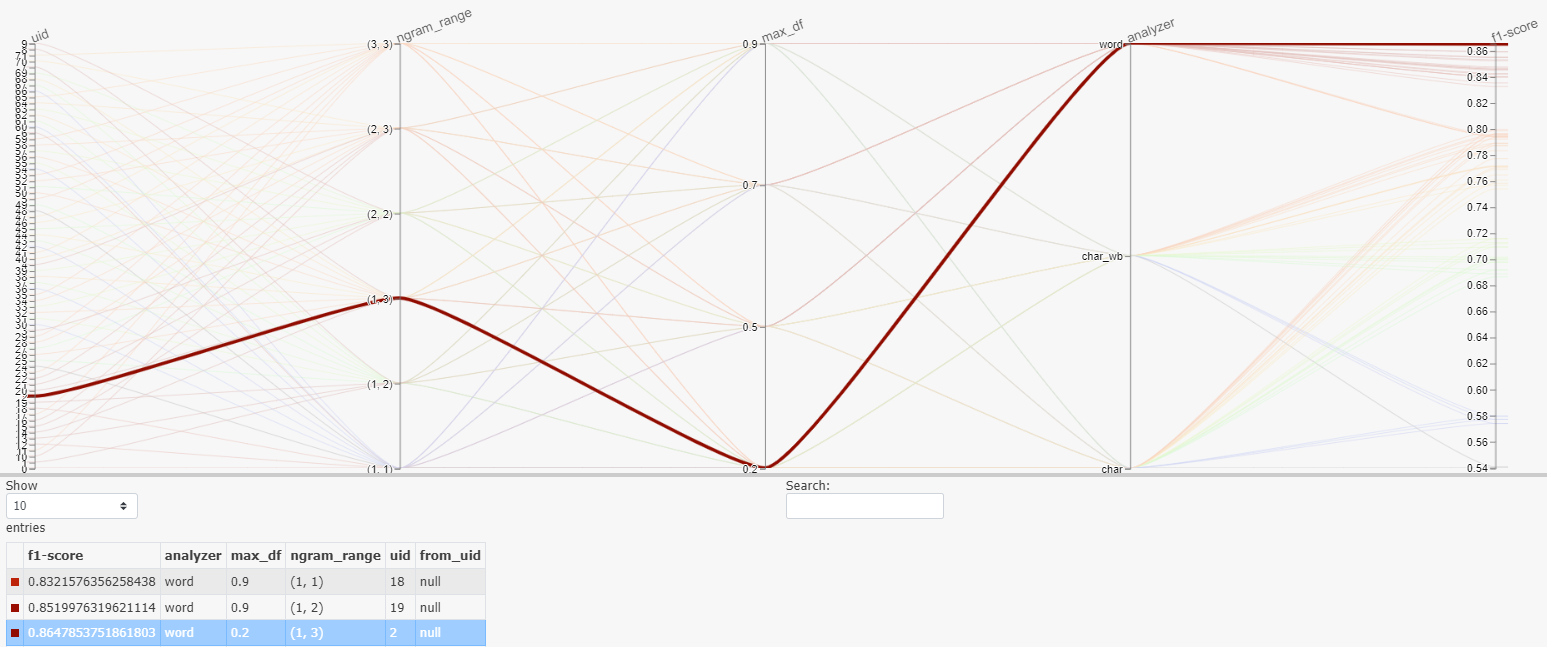

Pour connaitre l'impact des différents paramètre de ``CountVectorzier()``, j'ai utilisé l'outil HiPlot (développé par Facebook). On peut facilement observer que l'ensemble des paramètres qui donne le meilleur f1-score sont:

- ``analyzer`` = word
- ``max_df`` = 0.2
- ``ngram_range`` = (1,3)


#### Tf-idf:

Il s'agit du produit de la fréquence du terme (TF) et de sa fréquence inverse dans les documents (IDF).
Cette méthode est habituellement utilisée pour extraire l'importance d'un terme $i$ dans un document $j$ relativement au reste du corpus, à partir d'une matrice d'occurences $mots \times documents$. Ainsi, pour une matrice $\mathbf{T}$ de $|V|$ termes et $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

On peut l'adapter à notre cas en considérant que le contexte du deuxième mot est le document. Cependant, TF-IDF est généralement plus adaptée aux matrices peu denses, puisque cette mesure pénalisera les termes qui apparaissent dans une grande partie des documents. 

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

features names

-------------------------

Vocabulary
{'bought': 1187, 'blockbuster': 1145, 'guy': 3338, 'behind': 1054, 'said': 6695, 'reason': 6484, 'cheap': 1690, 'disc': 2196, 'failed': 2654, 'mention': 5099, 'poor': 6242, 'effort': 2393, 'sucked': 7421, 'harder': 3400, 'paris': 6058, 'hotel': 3740, 'room': 6662, 'home': 3708, 'video': 9245, 'talking': 7511, 'videos': 9248, 'since': 7050, 'fair': 2660, 'game': 3124, 'release': 6529, 'films': 2844, 'mean': 5062, 'say': 6730, 'used': 9179, 'actors': 131, 'your': 9985, 'friends': 3065, 'lame': 4626, 'ideas': 3798, 'together': 8931, 'weekend': 9500, 'production': 6334, '00': 0, 'budget': 1387, 'someone': 7167, 'fall': 2667, 'down': 2297, 'soundtrack': 7201, 'slap': 7080, 'take': 7491, 'lonely': 4823, 'desperation': 2110, 'here': 3591, 'fast': 2706, 'through': 8626, 'side': 7028, 'ready': 6457, 'until': 9138, 'next': 5460, 'night': 5468, 'while': 9620, 'watching': 9441, 'day': 2032, 'horror': 3729, '99': 54, 'keep': 4550, 'different': 2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[[1 0 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

-------------------------

TF-IDF
[6.44924025 5.79159976 3.00777917 ... 5.43131687 5.60527018 6.33923936]
10000

-------------------------

Predictions
[1 1 1 ... 1 0 0]


---- Classification report ----
              precision    recall  f1-score   support

     positif       0.89      0.85      0.87      1280
     negatif       0.85      0.89      0.87      1220

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500



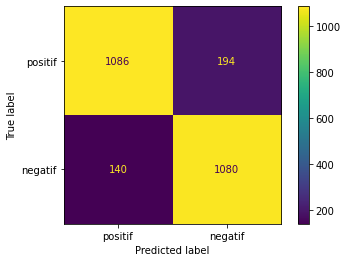

In [ ]:
# You can use Pipeline here too
pipe = Pipeline([('vec_count', CountVectorizer(max_features= 10000, analyzer='word', max_df=0.2, ngram_range=(1,3))), 
                 ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB())
                 ])

pipe.fit(train_texts_splt, train_labels_splt)

print("features names")
feat_names = pipe['vec_count'].get_feature_names()

print("\n-------------------------\n")

print("Vocabulary")
vocab = pipe['vec_count'].vocabulary_
print(vocab)

print("\n-------------------------\n")

print("CountVectorizer")
vec_count = pipe['vec_count'].transform(train_texts_splt).toarray()
print(vec_count)

print("\n-------------------------\n")

print("TF-IDF")
tf_idf = pipe['tfidf'].idf_
print(tf_idf)
print(len(tf_idf))

print("\n-------------------------\n")

# Make predictions
predictions = pipe.predict(val_texts)

print("Predictions")
print(predictions)

# Show the results in a readable format
print("\n\n---- Classification report ----")

report_classification = classification_report(val_labels, predictions, target_names=["positif", "negatif"], output_dict=True)

print(classification_report(val_labels, predictions, target_names=["positif", "negatif"]))

cm = confusion_matrix(val_labels, predictions)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=["positif", "negatif"])

cm_disp.plot()
plt.show()

### Outils de prétraitement: NLTK

On va maintenant chercher à pré-traiter nos données de manière à simplifier la tâche du modèle. **Notez toujours que celà ne sera probablement utile que si l'on a trop peu de données à disposition !**

#### Stemming: 

Permet de revenir à la racine d'un mot: on peut ainsi grouper différents mots autour de la même racine, ce qui facilite la généralisation. On peut utiliser l'outil ```SnowballStemmer```.

In [21]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

Exemple d'utilisation:

In [22]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))#.decode('utf-8'))))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


Transformation des données:

In [23]:
def stem(word): 
# To complete
  stemmer = SnowballStemmer("english")
  word_stemmed = stemmer.stem(word)

  result = [word, word_stemmed]
  return result

**Test de la fonction ``stem``**

In [24]:
# Test it on the dataset
sentence = train_texts_reduced[0] # test on the first sentence of our dataset
print("--- Original sentence ---")
print(sentence)

list_words = sentence.split(" ")

list_word_stemmed = list()
for word in list_words:
  stemmed_word = stem(word)
  list_word_stemmed.append(stemmed_word)

print("\n\n--- Stemmed words ---")
list_word_stemmed

--- Original sentence ---
Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.


--- Stemmed words ---


[['Story', 'stori'],
 ['of', 'of'],
 ['a', 'a'],
 ['man', 'man'],
 ['who', 'who'],
 ['has', 'has'],
 ['unnatural', 'unnatur'],
 ['feelings', 'feel'],
 ['for', 'for'],
 ['a', 'a'],
 ['pig.', 'pig.'],
 ['Starts', 'start'],
 ['out', 'out'],
 ['with', 'with'],
 ['a', 'a'],
 ['opening', 'open'],
 ['scene', 'scene'],
 ['that', 'that'],
 ['is', 'is'],
 ['a', 'a'],
 ['terrific', 'terrif'],
 ['example', 'exampl'],
 ['of', 'of'],
 ['absurd', 'absurd'],
 ['comedy.', 'comedy.'],
 ['A', 'a'],
 ['formal', 'formal'],
 ['orchestra', 'orchestra'],
 ['audience', 'audienc'],
 ['is', 'is'],
 ['turned', 'turn'],
 ['into', 'into'],
 ['an', 'an'],
 ['insane,', 'insane,'],
 ['violent', 'violent'],
 ['mob', 'mob'],
 ['by', 'by'],
 ['the', 'the'],
 ['crazy', 'crazi'],
 ['chantings', 'chant'],
 ['of', 'of'],
 ["it's", 'it'],
 ['singers.', 'singers.'],
 ['Unfortunately', 'unfortun'],
 ['it', 'it'],
 ['stays', 'stay'],
 ['absurd', 'absurd'],
 ['the', 'the'],
 ['WHOLE', 'whole'],
 ['time', 'time'],
 ['with', 'with'

**Construction d'une fonction de preprocessing pour stemmatiser notre corpus de texte**

In [36]:
def preprocess_stem(text):
    list_words = text.split(" ")
    
    text_ = ' '.join([stemmer.stem(word) for word in list_words])

    return text_

**On applique la fonction de preprocessing**

In [37]:
text_train_stemmed = list()
for elm in train_texts_splt:
  elm_preprocessed = preprocess_stem(elm)
  text_train_stemmed.append(elm_preprocessed)

print(len(text_train_stemmed))

10000


**On appique la pipeline ``{CountVectorizer, TF-IDF, MultinomialNB}``** 

features names

-------------------------

Vocabulary
{'saw': 6760, 'becam': 1057, 'ever': 2584, 'walk': 9280, 'middle': 5190, 'noth': 5621, 'wors': 9822, 'comedi': 1867, 'miss': 5221, 'funny': 3132, 'everi': 2589, 'although': 313, 'speak': 7243, 'last': 4704, '25': 41, 'minut': 5212, 'origin': 6006, 'while': 9617, 'enjoy': 2502, 'humor': 3814, 'where': 9575, 'these': 8415, 'skit': 7100, 'needless': 5487, 'vulgar': 9272, 'irrit': 4127, 'advertis': 175, 'robin': 6673, 'william': 9698, 'capit': 1640, 'new': 5509, 'found': 3057, 'fame': 2709, 'televis': 7543, 'series': 6931, 'yet': 9904, 'role': 6679, 'turn': 9061, 'minor': 5211, 'cannot': 1635, 'notic': 5633, 'screen': 6830, 'when saw': 9565, 'saw this': 6763, 'this movie': 8579, 'the first': 7911, 'first movi': 2915, 'movi that': 5352, 'walk out': 9283, 'out of': 6046, 'there is': 8390, 'is noth': 4232, 'wors than': 9823, 'comedi that': 1869, 'that just': 7647, 'be funny': 1018, 'funny and': 3133, 'and this': 580, 'everi time': 2593, 't

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

-------------------------

TF-IDF
[6.52156091 5.76778911 3.00703485 ... 6.68407984 6.1673891  6.18508868]
10000

-------------------------

Predictions
[1 0 1 ... 1 0 1]


---- Classification report ----
              precision    recall  f1-score   support

     positif       0.84      0.85      0.85      1267
     negatif       0.84      0.84      0.84      1233

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



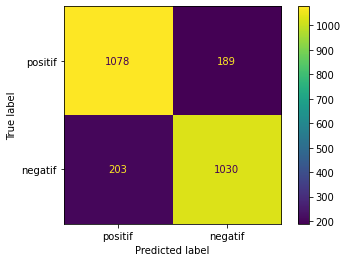

In [38]:
pipe = Pipeline([('vec_count', CountVectorizer(max_features= 10000, analyzer='word', max_df=0.2, ngram_range=(1,3))), 
                 ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB())
                 ])

pipe.fit(text_train_stemmed, train_labels_splt)

print("features names")
feat_names = pipe['vec_count'].get_feature_names()

print("\n-------------------------\n")

print("Vocabulary")
vocab = pipe['vec_count'].vocabulary_
print(vocab)

print("\n-------------------------\n")

print("CountVectorizer")
vec_count = pipe['vec_count'].transform(text_train_stemmed).toarray()
print(vec_count)

print("\n-------------------------\n")

print("TF-IDF")
tf_idf = pipe['tfidf'].idf_
print(tf_idf)
print(len(tf_idf))

print("\n-------------------------\n")

# Make predictions
predictions = pipe.predict(val_texts)

print("Predictions")
print(predictions)

# Show the results in a readable format
print("\n\n---- Classification report ----")

report_classification = classification_report(val_labels, predictions, target_names=["positif", "negatif"], output_dict=True)

print(classification_report(val_labels, predictions, target_names=["positif", "negatif"]))

cm = confusion_matrix(val_labels, predictions)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=["positif", "negatif"])

cm_disp.plot()
plt.show()

#### Partie du discours

Pour généraliser, on peut aussi utiliser les parties du discours (Part of Speech, POS) des mots, ce qui nous permettra  de filtrer l'information qui n'est potentiellement pas utile au modèle. On va récupérer les POS des mots à l'aide des fonctions ```pos_tag, word_tokenize```.

In [39]:
import nltk
from nltk import pos_tag, word_tokenize

Exemple d'utilisation:

In [40]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

Transformation des données:

Ne garder que les noms, adverbes, verbes et adjectifs (```['NN', 'VB', 'ADJ', 'RB']```) pour notre modèle. 

In [41]:
def pos_tag_filter(sentence, good_tags=['NN', 'VB', 'ADJ', 'RB']):
# To complete !
  sentence_tokenized = word_tokenize(sentence)

  list_tag = pos_tag(sentence_tokenized)

  list_accepted_pos_tag = list()

  for tag in list_tag:
    if tag[1] in good_tags:
      list_accepted_pos_tag.append(tag)
  
  return list_accepted_pos_tag

**Test de la fonction ``pos_tagfilter``**

In [42]:
# Test it on the dataset
sentence = train_texts_reduced[0] # test on the first sentence of our dataset
print("--- Original phrase ---")
print(sentence)

print("\n\n--- Pos Tags ---")
pos_tag_filter(sentence)

--- Original phrase ---
Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.


--- Pos Tags ---


[('Story', 'NN'),
 ('man', 'NN'),
 ('pig', 'NN'),
 ('opening', 'NN'),
 ('scene', 'NN'),
 ('example', 'NN'),
 ('comedy', 'NN'),
 ('orchestra', 'NN'),
 ('audience', 'NN'),
 ('insane', 'NN'),
 ('mob', 'NN'),
 ('Unfortunately', 'RB'),
 ('time', 'NN'),
 ('eventually', 'RB'),
 ('just', 'RB'),
 ('too', 'RB'),
 ('Even', 'RB'),
 ('era', 'NN'),
 ('be', 'VB'),
 ('dialogue', 'NN'),
 ('make', 'VB'),
 ('seem', 'VB'),
 ('grader', 'NN'),
 ('level', 'NN'),
 ('think', 'VB'),
 ('cinematography', 'NN'),
 ('be', 'VB'),
 ('briefly', 'NN')]

**Construction d'une fonction de preprocessing pour stemmatiser et filter les tags notre corpus de texte**

In [54]:
def preprocess_stem_filter(text):
    list_words = text.split(" ")
    
    # on stemmatise la phrase
    text_1 = ' '.join([stemmer.stem(word) for word in list_words])

    # On garde uniquement les mots associés aux bons tags
    text_2 = pos_tag_filter(text_1, good_tags=['NN', 'VB', 'ADJ', 'RB'])

    # Reconstruction la phrase
    text_3 = " ".join([i[0] for i in text_2])

    return text_3

In [58]:
text_train_stemmed_filtered = list()
for elm in train_texts_splt:
  elm_preprocessed = preprocess_stem_filter(elm)
  text_train_stemmed_filtered.append(elm_preprocessed)

print(len(text_train_stemmed_filtered))

10000


**On appique la pipeline ``{CountVectorizer, TF-IDF, MultinomialNB}``** 

features names

-------------------------

Vocabulary
{'ever': 3173, 'middle': 5778, 'comedi': 2125, 'everi': 3195, 'speak': 8415, 'minut': 5817, 'origin': 6657, 'ani': 341, 'humor': 4576, 'vulgar': 9538, 'irrit': 4805, 'advertis': 152, 'robin': 7647, 'william': 9803, 'capit': 1734, 'fame': 3332, 'televis': 8851, 'series': 8017, 'role': 7667, 'movi ever': 6004, 'just be': 4961, 'everi time': 3200, 'minut movie': 5824, 'robin william': 7648, 'role be': 7668, 'be so': 789, 'so not': 8307, 'not even': 6394, 'mani': 5609, 'action': 84, 'star': 8495, 'tv': 9336, 'tape': 8818, 'tripe': 9303, 'bizarr': 971, 'reason': 7409, 'blame': 982, 'something': 8366, 'uniqu': 9386, 'hype': 4594, 'joel': 4905, 'silver': 8165, 'touch': 9226, 'want': 9561, 'first': 3717, 'onli': 6616, 'valu': 9418, 'entir': 3076, 'zane': 9989, 'lift': 5315, 'perform': 6857, 'seem': 7979, 'know': 5130, 'do': 2728, 'here': 4391, 'though': 9040, 'writing': 9921, 'quit': 7289, 'frankly': 3824, 'let': 5260, 'take': 8792, 'idea':

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

-------------------------

TF-IDF
[6.25919665 7.72553372 7.07494615 ... 7.43785164 7.90785527 7.90785527]
10000

-------------------------

Predictions
[1 0 0 ... 0 0 0]


---- Classification report ----
              precision    recall  f1-score   support

     positif       0.58      0.97      0.73      1267
     negatif       0.89      0.29      0.44      1233

    accuracy                           0.63      2500
   macro avg       0.74      0.63      0.58      2500
weighted avg       0.74      0.63      0.58      2500



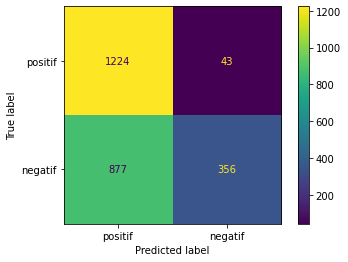

In [59]:
pipe = Pipeline([('vec_count', CountVectorizer(max_features= 10000, analyzer='word', max_df=0.2, ngram_range=(1,3))), 
                 ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB())
                 ])

pipe.fit(text_train_stemmed_filtered, train_labels_splt)

print("features names")
feat_names = pipe['vec_count'].get_feature_names()

print("\n-------------------------\n")

print("Vocabulary")
vocab = pipe['vec_count'].vocabulary_
print(vocab)

print("\n-------------------------\n")

print("CountVectorizer")
vec_count = pipe['vec_count'].transform(text_train_stemmed_filtered).toarray()
print(vec_count)

print("\n-------------------------\n")

print("TF-IDF")
tf_idf = pipe['tfidf'].idf_
print(tf_idf)
print(len(tf_idf))

print("\n-------------------------\n")

# Make predictions
predictions = pipe.predict(val_texts)

print("Predictions")
print(predictions)

# Show the results in a readable format
print("\n\n---- Classification report ----")

report_classification = classification_report(val_labels, predictions, target_names=["positif", "negatif"], output_dict=True)

print(classification_report(val_labels, predictions, target_names=["positif", "negatif"]))

cm = confusion_matrix(val_labels, predictions)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=["positif", "negatif"])

cm_disp.plot()
plt.show()

#### Discussion des résultats

Sans grande surprise les performances baissent lorsque l'on appriche la fonction ``pos_tag_filter`` en ne gardant uniquement que les mots associés aux tags acceptés, la phrase perd de son sens. De plus, la phrase n'est plus bien construire.

## Fine-tuning d'un modèle Bert

Suivant le modèle du TP précédent, fine-tunez le modèle Bert le plus léger disponible sur les données d'IMDB et comparez avec les résultats obtenus précédemment. **Encore une fois, si possible, réalisez cette étude pour des quantités de données différentes.**

**Check if the GPU is available**

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


**Installation the dependences**

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

import pprint
pp = pprint.PrettyPrinter(indent=4)

#### Encoding data with DistilBERT

1. Le texte doit être tronqué s'il est supérieur à 256/512 tokens ou paddé s'il est inférieur à 256 ou 512 tokens (selon la taille du modèle). Les mots peuvent également devoir être séparés en sous-mots : Les modèles de type BERT utilisent des *tokenizers* différents, construits pour gérer un vocabulaire de taille fixe. Tout mot qui n'est pas dans le vocabulaire est divisé en sous-mots qui le sont. Le tokenizer de BERT est basé sur *Wordpiece*. 

2. BERT utilise des jetons spéciaux, qui seront ajoutés :
    - [CLS] - Jeton de début de chaque document.
    - [SEP] - Séparateur entre chaque phrase. 
    - [PAD] - Remplissage à la fin du document autant de fois que nécessaire, jusqu'à 256/512 jetons.
    - &#35;&#35; - Indique le début d'un sous-mot, ou "morceau de mot".  

Nous utiliserons le modèle **DistilBERT** pour gagner de la place (puisqu'il s'agit d'une version distillée du modèle BERT complet), et nous utiliserons la version sans casse. Nous devons faire attention à utiliser le tokenizer correspondant. 

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

**Encoding training and testing data**

In [ ]:
train_texts_input = tokenizer([sentence for sentence in train_texts_splt],
                         truncation=True,
                         padding='max_length', 
                         return_tensors="pt")

test_texts_input = tokenizer([sentence for sentence in val_texts],
                              truncation=True,
                              padding='max_length', 
                              return_tensors="pt")

**Regardons le résultat de l'encodage du dataset d'entrainement**

Pour ce nous allons prendre comme exemple la première phrase de notre dataset que l'on peut considéré comme un document

Résultat de l'encoding ``train_texts_input``

In [ ]:
print("----- train_texts_input -----")

print("Original sentence")
print(train_texts_splt[0])

print("\n\nTokens")
pp.pprint(train_texts_input[0].tokens)

print("\n\nSpecial Tokens")
pp.pprint(train_texts_input[0].special_tokens_mask)

# The number of tokens is not the same anymore
print("\n\nText length")
pp.pprint(len(train_texts_splt[0]))

print("\n\nText tokenized length")
pp.pprint(len(train_texts_input[0].tokens))

----- train_texts_input -----
Original sentence
I bought this from Blockbuster for 99p. The guy behind the counter said the reason it was so cheap was because the disc was scratched to sh*t, but failed to mention that the reason it was so cheap was because the film was a p*ss poor effort that sucked harder than Paris Hilton in a hotel room home video. Talking of home videos, since when has it been fair game to release them as films - I mean to say, films used to employ actors and technicians and scriptwriters and so on - not any more - just gather your friends and lame-o ideas together for the weekend, lavish the production with an £8.00 budget, and get someone to fall down the stairs with a Casio keyboard (the soundtrack) - then slap it on the shelves, for some poor sap (me), to take home in lonely desperation. But here's the clincher - I fast forwarded through most of this, and tossed it to one side, ready for the hammers... until the next night, while watching a Darren Day horror 'H

Résultat de l'encoding de ``test_texts_input``

In [ ]:
print("----- test_texts_input -----")

print("Original sentence")
print(val_texts[0])

print("\n\nTokens")
pp.pprint(test_texts_input[0].tokens)

print("\n\nSpecial Tokens")
pp.pprint(test_texts_input[0].special_tokens_mask)

# The number of tokens is not the same anymore
print("\n\nText length")
pp.pprint(len(val_texts[0]))

print("\n\nText tokenized length")
pp.pprint(len(test_texts_input[0].tokens))

----- test_texts_input -----
Original sentence
The Twilight Zone has achieved a certain mythology about it--much like Star Trek. That's because there are many devoted lovers of the show that no matter what think every episode was a winner. They are the ones who score each individual show a 10 and cannot objectively evaluate the show. Because of this, a while back I reviewed all the original Star Trek episodes (the good and the bad) because the overall ratings and reviews were just too positive. Now, it's time to do the same for The Twilight Zone.<br /><br />While I have scored many episodes 10, this one gets a 3 simply because it was bad. The writing was in fact embarrassingly bad. Two people from opposing sides in a great war are seen wandering about through the entire episode. After a while, it's apparent that they are the only two people left on Earth--as you learn in the really stupid and totally unconvincing conclusion. Usually the twist at the end makes the episode great--this on

On peut remarquer que l'encodage du premier document (i.e premier texte) est composé à la fin d'une séquence du token ``[PAD]``. Cela s'exeplique par le fait que la longueur de la séquence n'est pas assez grand pour tenir sur un séquence de dmiension 512. Ainsi la fin de l'encodage de la fin de la séquence est remplie par le token ``[PAD]`` pour respecter une séquence de 512

**Création de la classe ``Torch``**

Nous devons créer une classe Torch personnalisée pour transformer les encodages en entrées du modèle, pour deux raisons principales :
- Ajouter les étiquettes à l'objet d'encodage, puisque cela est nécessaire pour affiner un modèle de classification.
- Fournir une interface pour le modèle pour faire des mini-batchs à partir des encodages.  

In [ ]:
import torch

class FineTuningDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_texts_dataset = FineTuningDataset(train_texts_input, train_labels_splt)
test_texts_dataset = FineTuningDataset(test_texts_input, val_labels)

**Load the model and pass to CUDA**

In [ ]:
bert_clf_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels= max(train_labels_splt) + 1).to("cuda")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

**On défini la métrique d'évaluation**

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)

  return {
      'accuracy': acc,
  }

**On défni les argument de l'entrainement**

In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

In [ ]:
bert_trainer = Trainer(
    model=bert_clf_model,                      
    args=training_args,                  
    train_dataset=train_texts_dataset,         
    eval_dataset=test_texts_dataset,           
    compute_metrics=compute_metrics       
)

**On entraine le modèle BERT**

In [ ]:
bert_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1875
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


***** Running Evaluation *****
  Num examples = 2500
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
***** Running Evaluation *****
  Num examples = 2500
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
***** Running Evaluation *****
  Num examples = 2500
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

TrainOutput(global_step=1875, training_loss=0.1859624917348226, metrics={'train_runtime': 2331.4005, 'train_samples_per_second': 12.868, 'train_steps_per_second': 0.804, 'total_flos': 3974021959680000.0, 'train_loss': 0.1859624917348226, 'epoch': 3.0})

**On évalue le modèle**

In [ ]:
bert_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2500
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


{'epoch': 3.0,
 'eval_accuracy': 0.9124,
 'eval_loss': 0.39310315251350403,
 'eval_runtime': 46.3073,
 'eval_samples_per_second': 53.987,
 'eval_steps_per_second': 2.699}

**Synthèse et discussion des résultats**

| Modèle  | Accuracy          |
| :--------------- |:---------------| 
| ``{CountVertorizer + MultinomialNB}``  |   0.86        |
| ``{CountVertorizer + TF-IDF + MultinomialNB}``  |   0.87        |
| `` Stemming + {CountVertorizer + TF-IDF + MultinomialNB}``  |   0.84        |
| `` Stemming + Pos Tag Filter + {CountVertorizer + TF-IDF + MultinomialNB}``  |   0.63        |
| ``{DistilBERT}``  |   0.912        |

<br>

En effet, le modèle ``{CountVertorizer + MultinomialNB}`` obtient des résultats très différent en fonction des hyperparamètres choisis pour ``CountVectorizer``. Toutefois, grâce au fait que nous avons "fine-tuné" les hyperparamètres du modèle nous avons été en mesure de trouver la meilleure combinaison des hyperparamètres qui maximise la métrique de l'accuracy. 

En utilisant les mêmes hyperparamètres du ``CountVertorizer`` du modèle précédent pour le modèle ``{CountVertorizer + TF-IDF + MultinomialNB}``, nous avons obtenu une meilleure accuracy. En y ajoutant un modèle ``TF-IDF`` nous avons réussi à améliorer les représentations du ```BoW``.

Toutefois, sans grande surprise, on constate que le modèle ``BERT`` surclasse les autres modèles de classification.  





